# Check dataflow

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

In [3]:
root_path = os.path.abspath("..")
if root_path not in sys.path:
    sys.path.append(root_path)

In [4]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [5]:
from common.dataflow import get_train_df, get_test_df, get_image, get_target, get_inc_angle
from common.dataflow_visu_utils import display_image
from common.dataflow import IcebergDataset

In [6]:
from common.dataflow_visu_utils import display_dataset, display_data_augmentations, display_batches

In [7]:
trainval_ds = IcebergDataset('Train')

x:  <class 'numpy.ndarray'> (75, 75, 2) -38.2114 -0.213149 -41.1359 -11.2522
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -23.1253 12.5704 -34.7658 0.044052
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -33.3912 -9.91848 -34.1488 -15.6059
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -32.2041 4.79563 -39.5641 -5.55452
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -35.0105 -6.95604 -40.2761 -9.43401
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -29.7157 3.86404 -37.674 -9.12756
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -35.9261 -10.3501 -36.8422 -17.4397
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -37.3003 -13.9976 -37.2979 -22.1081
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -25.7325 28.5789 -34.252 -1.07451
y:  <class 'numpy.int64'> ()
x:  <class 'numpy.ndarray'> (75, 75, 2) -36.0653 -5.6063 -38

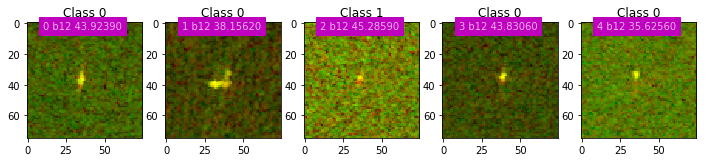

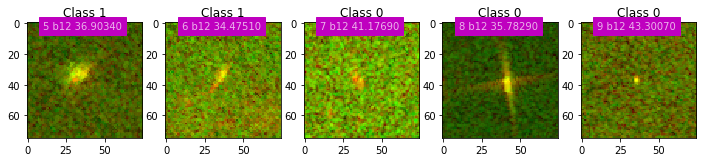

In [9]:
display_dataset(trainval_ds, max_datapoints=10, show_info=True)

In [10]:
%%timeit -r2 -n5
for (x, a), y in trainval_ds:
    x.sum()

1.26 s ± 10.5 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


Compute min, max, mean on the train dataset

In [9]:
min_vals = [] 
max_vals = []
mean_vals = []
for (x, a), y in trainval_ds:
    min_vals.append((x[:, :, 0].min(), x[:, :, 1].min()))
    max_vals.append((x[:, :, 0].max(), x[:, :, 1].max()))
    mean_vals.append((x[:, :, 0].mean(), x[:, :, 1].mean()))
    
min_vals = np.array(min_vals)
max_vals = np.array(max_vals)
mean_vals = np.array(mean_vals)

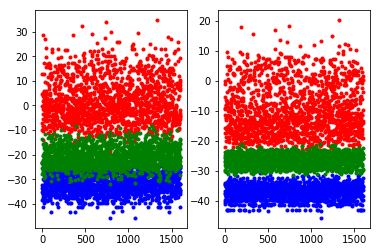

In [10]:
plt.subplot(121)
plt.plot(min_vals[:, 0], 'b.', label='mins')
plt.plot(max_vals[:, 0], 'r.', label='maxs')
plt.plot(mean_vals[:, 0], 'g.', label='mean')
plt.subplot(122)
plt.plot(min_vals[:, 1], 'b.', label='mins')
plt.plot(max_vals[:, 1], 'r.', label='maxs')
plt.plot(mean_vals[:, 1], 'g.', label='mean')

In [25]:
np.percentile(mean_vals, q=50.0, axis=0), np.percentile(max_vals, q=97.0, axis=0) - np.percentile(min_vals, q=3.0, axis=0)

(array([-21.04982662, -26.15313911]), array([ 59.87096096,  48.35116971]))

In [13]:
import torch
from common.torch_common_utils.dataflow import TransformedDataset, OnGPUDataLoader
from common.dataflow import get_data_transforms

In [26]:
train_aug_str = '''{
    "Compose":
        {"transforms": [{"RandomChoice": {"transforms": [
                            {"RandomAffine": {"translate": [0.075, 0.075],
                                              "rotation": [-90, 90],                                                
                                              "interpolation": 0}},
                            {"RandomFlip": {"mode": "h", "proba": 0.5}},
                            {"RandomFlip": {"mode": "v", "proba": 0.5}}]}},
                        {"_ToTensor": {}},
                        {"Normalize": {"mean": [-21.04982662, -26.15313911],
                                       "std": [59.87096096,  48.35116971]}}                        
                        ]
        }
    }
'''
train_aug = get_data_transforms(train_aug_str)


test_aug_str = '''{
    "Compose":
        {"transforms": [{"_ToTensor": {}},
                        {"Normalize": {"std": [33.44618988,  26.86827087],
                                        "mean": [-20.65583038, -26.32068253]}}]
        }
    }
'''
test_aug = get_data_transforms(test_aug_str)

In [27]:
from functools import partial

def x_transform(x, aug_fn):
    x, a = x
    x = aug_fn(x)
    return x, a

def y_transform(y):
    return torch.FloatTensor([int(y)])

In [28]:
train_aug_ds = TransformedDataset(trainval_ds, 
                                  x_transforms=partial(x_transform, aug_fn=train_aug), 
                                  y_transforms=y_transform)

val_aug_ds = TransformedDataset(trainval_ds, 
                                x_transforms=partial(x_transform, aug_fn=test_aug), 
                                y_transforms=y_transform)

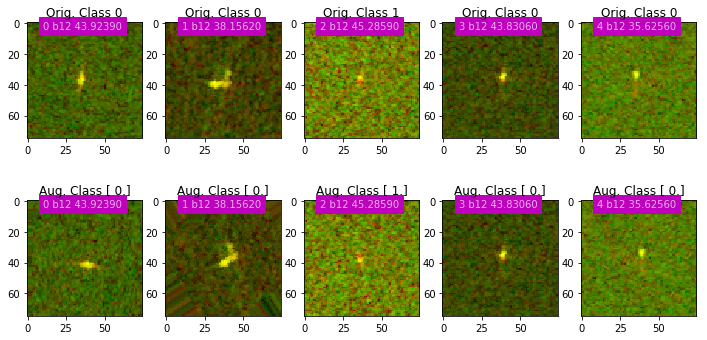

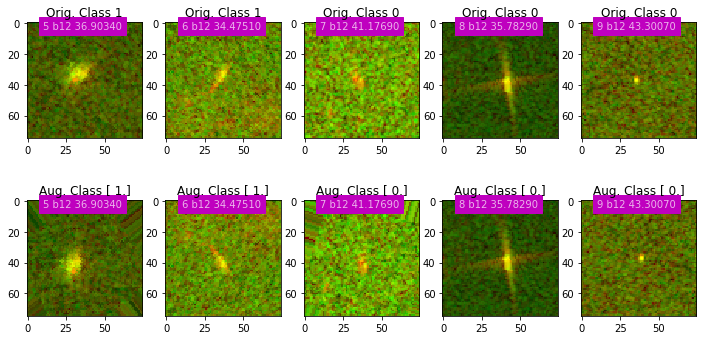

In [29]:
display_data_augmentations(trainval_ds, train_aug_ds, max_datapoints=10)

x:  <class 'torch.FloatTensor'> torch.Size([2, 75, 75]) -0.221104234457016 0.005934018641710281 -0.2349308282136917 0.005917489994317293
y:  <class 'torch.FloatTensor'> torch.Size([1])
x:  <class 'torch.FloatTensor'> torch.Size([2, 75, 75]) -0.1107146292924881 0.21140557527542114 -0.09983961284160614 0.22586502134799957
y:  <class 'torch.FloatTensor'> torch.Size([1])
x:  <class 'torch.FloatTensor'> torch.Size([2, 75, 75]) -0.1394559144973755 0.13642171025276184 -0.1353108286857605 0.10668763518333435
y:  <class 'torch.FloatTensor'> torch.Size([1])
x:  <class 'torch.FloatTensor'> torch.Size([2, 75, 75]) -0.22562623023986816 0.039507314562797546 -0.20446838438510895 0.029620837420225143
y:  <class 'torch.FloatTensor'> torch.Size([1])
x:  <class 'torch.FloatTensor'> torch.Size([2, 75, 75]) -0.13931481540203094 0.11556103080511093 -0.1699608713388443 0.09594287723302841
y:  <class 'torch.FloatTensor'> torch.Size([1])


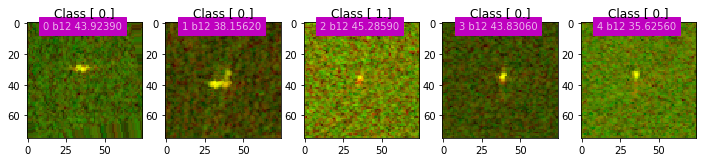

In [30]:
display_dataset(train_aug_ds, max_datapoints=5, show_info=True)

In [31]:
CONFIG = {
    'batch_size': 10,
    'num_workers': 12,
    'n_splits': 10,
    'val_size': 0.10,

    'seed': 12345
}

In [33]:
y_array = []
x_array = []
for i, ((x, a), y) in enumerate(trainval_ds):
    y_array.append(y)
    x_array.append(i)    

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit
# Stratified split:        
sssplit = StratifiedShuffleSplit(n_splits=CONFIG['n_splits'], 
                                 test_size=CONFIG['val_size'], 
                                 random_state=CONFIG['seed'])
train_indices, val_indices = next(sssplit.split(x_array, y_array))

In [35]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [39]:
train_batches = OnGPUDataLoader(train_aug_ds,
                                batch_size=CONFIG['batch_size'],
                                sampler=train_sampler,
                                num_workers=CONFIG['num_workers'],
                                drop_last=True,
                                pin_memory=True)

val_batches = OnGPUDataLoader(val_aug_ds,
                              batch_size=CONFIG['batch_size'],
                              sampler=val_sampler,
                              num_workers=CONFIG['num_workers'],
                              drop_last=True,
                              pin_memory=True)

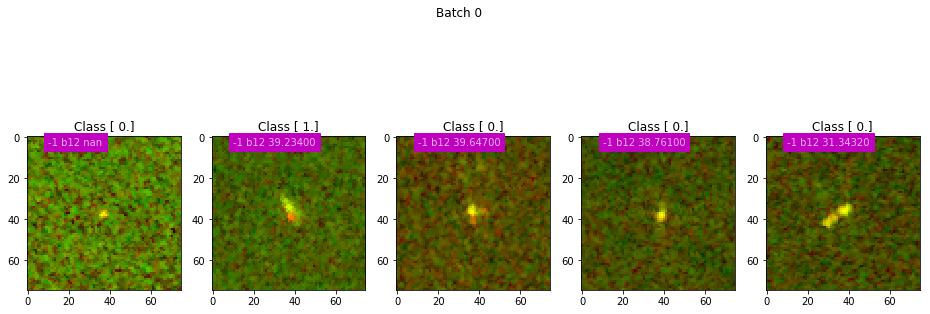

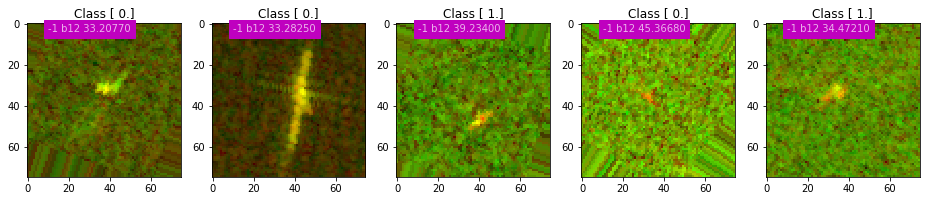

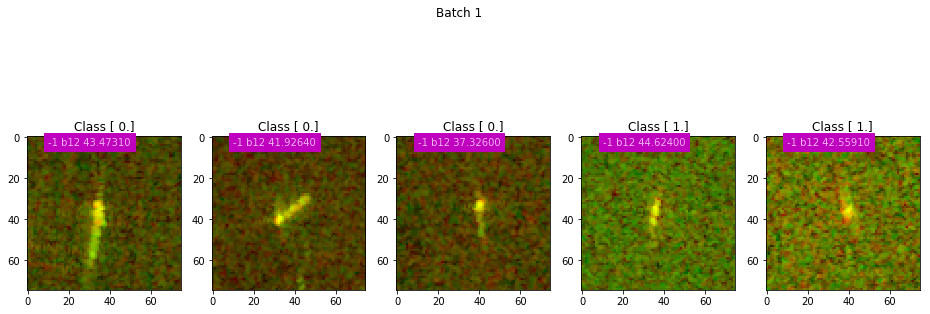

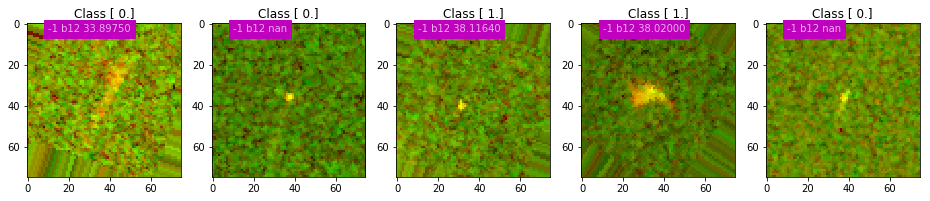

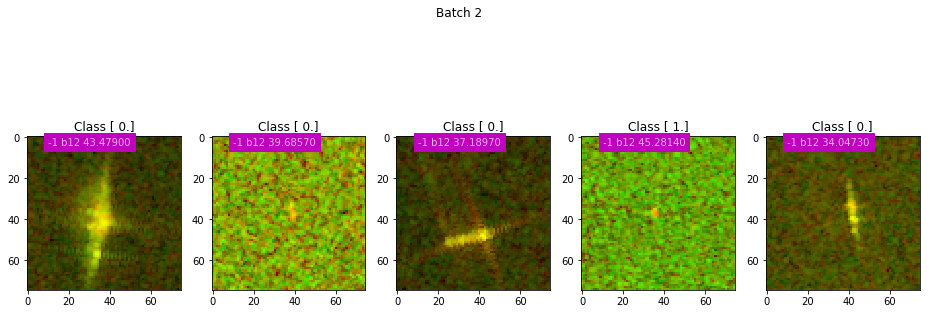

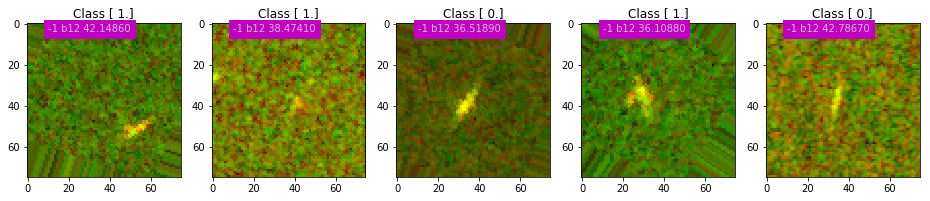

In [40]:
display_batches(train_batches)